In [1]:
#import sys
#sys.path.append("../")
import pandas as pd
import numpy as np
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.45. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [2]:
datapath = 'C:/Users/Ram/Documents/Ram/Data_Sets/'
#datapath = ''
#filename = 'openaq_0801-1031.csv'
filename = 'ts_2.csv'

In [3]:
dft = pd.read_csv(datapath+filename, parse_dates=True)
#dft = df.loc[df['city'] == 'Chennai']
#dft = dft.iloc[::48,]
print(dft.shape)
dft.head()

(486, 2)


,DATE,UMCSENT
0,1978-01-01,83.7
1,1978-02-01,84.3
2,1978-03-01,78.8
3,1978-04-01,81.6
4,1978-05-01,82.9


In [4]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=25)
i = 1
score = []
for fold_number, (tr_index, val_index) in enumerate(tscv.split(dft)):
    if i <= 1:
        print(fold_number+1)
        print(tr_index, val_index)
    i += 1

1
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

In [5]:
ts_column = 'DATE'
sep = ','
target = 'UMCSENT'
dft[[ts_column,target]].isnull().sum()

DATE       0
UMCSENT    0
dtype: int64

In [6]:
traindata = dft.iloc[tr_index]
testdata = dft.iloc[val_index]
print(traindata.shape, testdata.shape)

(461, 2) (25, 2)


dft = dft[[ts_column,target]]
dft = dft[dft[target]>0]
print(dft.shape)
dft.head(1)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |     -3.3023697130521867      |
|           p-value           |     0.014772879980967173     |
|          #Lags Used         |             0.0              |
| Number of Observations Used |            460.0             |
|     Critical Value (1%)     |      -3.44464601455782       |
|     Critical Value (5%)     |      -2.867843681679954      |
|     Critical Value (10%)    |      -2.570127622873346      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = UMCSENT
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_c

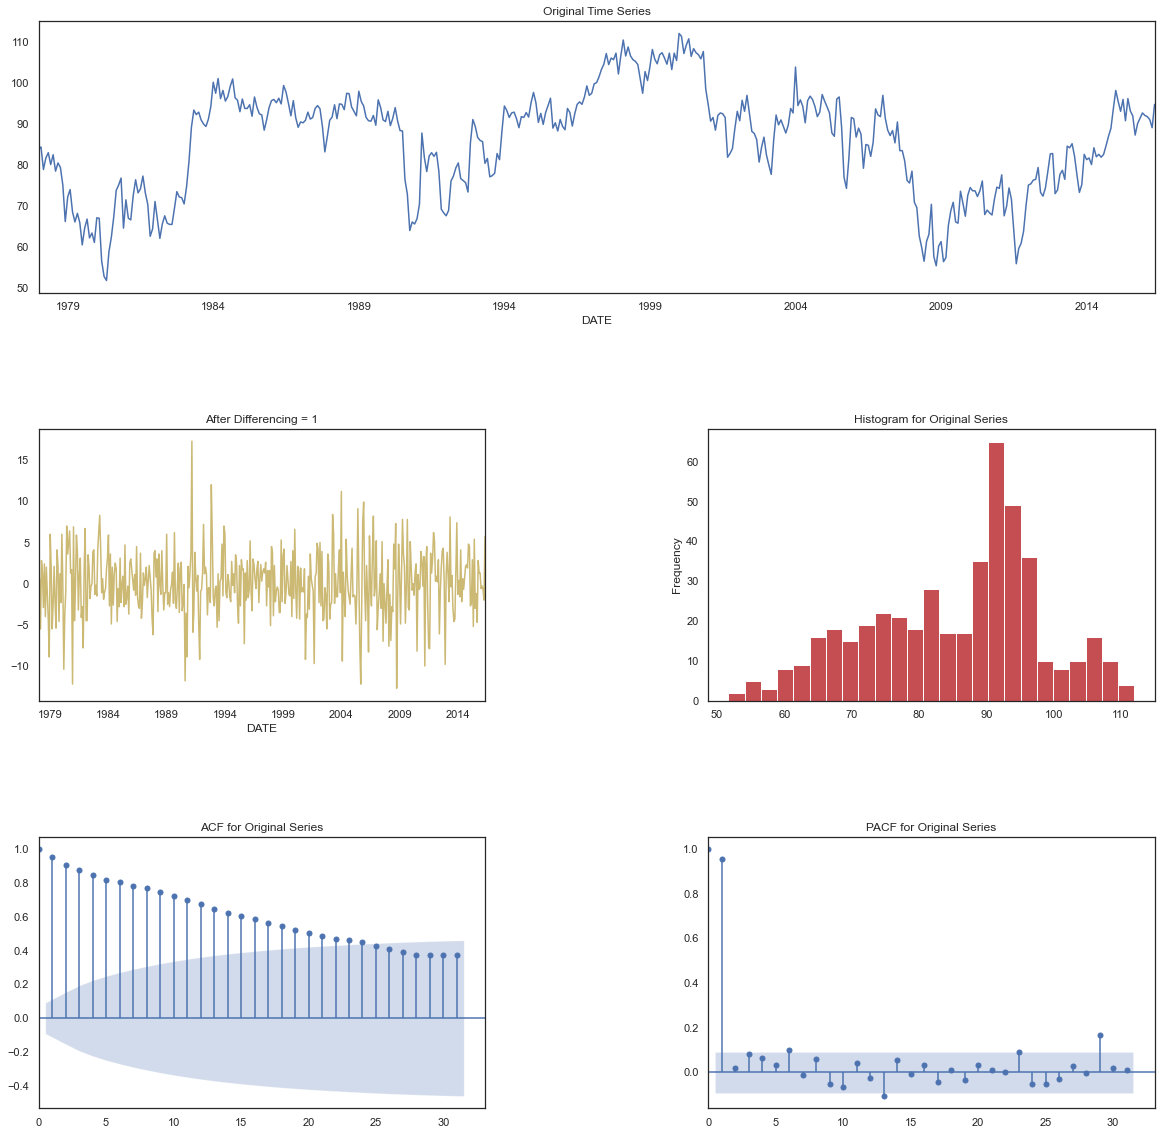

Time Interval is given as M
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(461, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 436 Test Shape: 5
    RMSE = 15.09
    Std Deviation of actuals = 1.01
    Normalized RMSE (as pct of std dev) = 1489%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 441 Test Shape: 5
    RMSE = 24.37
    Std Deviation of actuals = 4.15
    Normalized RMSE (as pct of std dev) = 588%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 446 Test Shape: 5
    RMSE = 22.06
    Std Deviation of actuals = 2.02
    Normalized RMSE (as pct of std dev) = 1091%
Cross Validation window: 3 completed

Fold Numb

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2517.847, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2515.962, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2519.912, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2517.680, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2513.917, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2514.335, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2518.293, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2515.884, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2521.324, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2513.999, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2517.934, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2515.717, Time=0.48 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 5.558 seconds

Best mod

    RMSE = 5.02
    Std Deviation of actuals = 2.02
    Normalized RMSE (as pct of std dev) = 248%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 447 Test Shape: 5
    RMSE = 4.74
    Std Deviation of actuals = 1.90
    Normalized RMSE (as pct of std dev) = 249%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 452 Test Shape: 5
    RMSE = 4.50
    Std Deviation of actuals = 1.84
    Normalized RMSE (as pct of std dev) = 245%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 3.85
    MSE (Mean Squared Error = 21.17
    MAPE (Mean Absolute Percent Error) = 4%
    RMSE (Root Mean Squared Error) = 4.6016
    Normalized RMSE (MinMax) = 28%
    Normalized RMSE (as Std Dev of Actuals)= 98%
Average CV RMSE of all predictions (micro) = 4.60159

Fitting model on entire train set. Please be patient...
    Time taken 

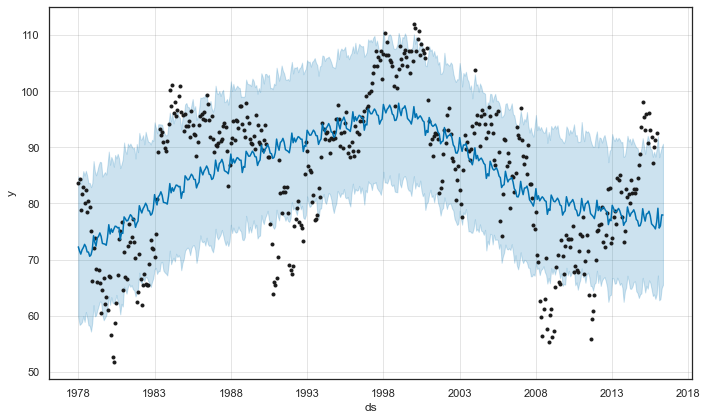

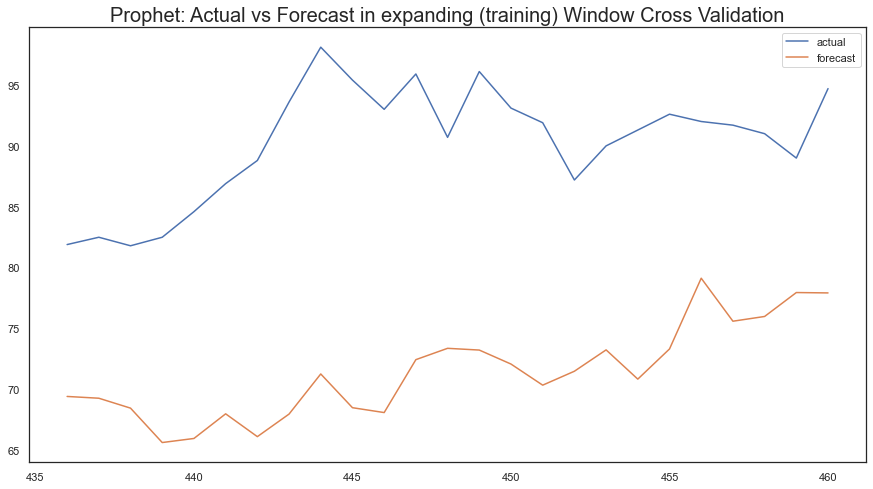

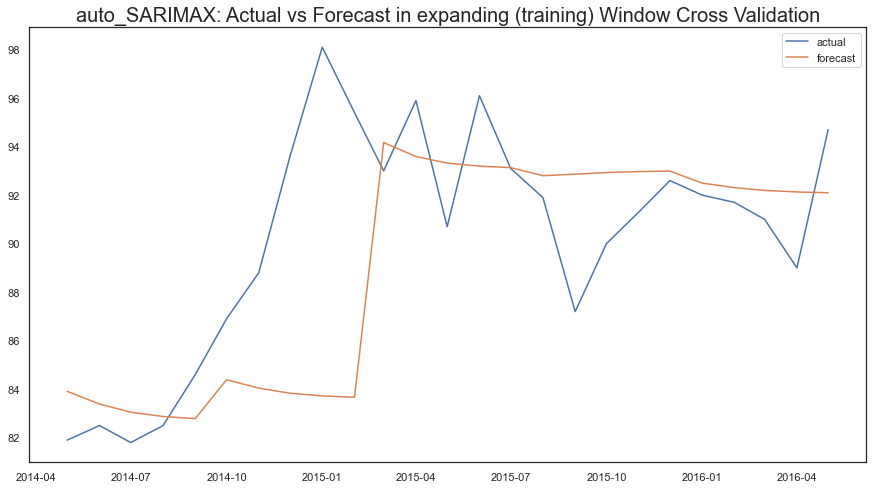

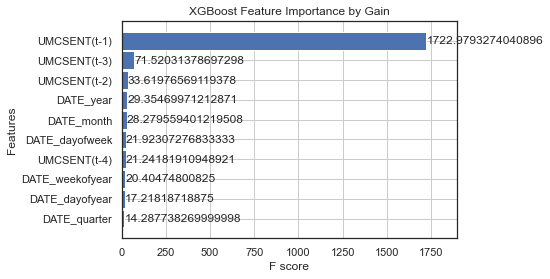

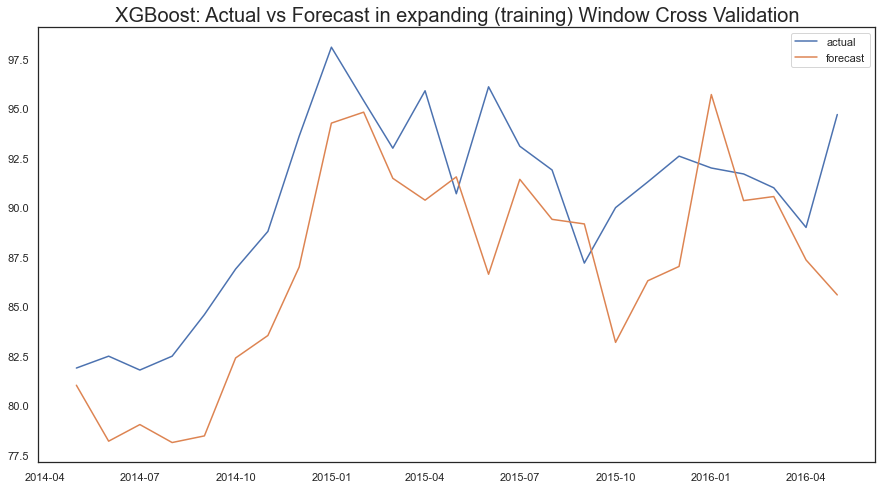

In [7]:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],dask_xgboost_flag=False,
                verbose=2)
model.fit(traindata, ts_column,target)


In [8]:
predictions  = model.predict(testdata, model='best')
predictions.head()

Predicting using test dataframe as input for auto_SARIMAX model


UMCSENT,yhat,mean_se,mean_ci_lower,mean_ci_upper
2016-06-01,94.826817,3.916391,87.150833,102.502802
2016-07-01,94.477085,5.422005,83.850151,105.104018
2016-08-01,94.246070,6.355517,81.789486,106.702654
2016-09-01,94.136700,7.039176,80.340169,107.933231
2016-10-01,94.102779,7.597575,79.211806,108.993753


<AxesSubplot:>

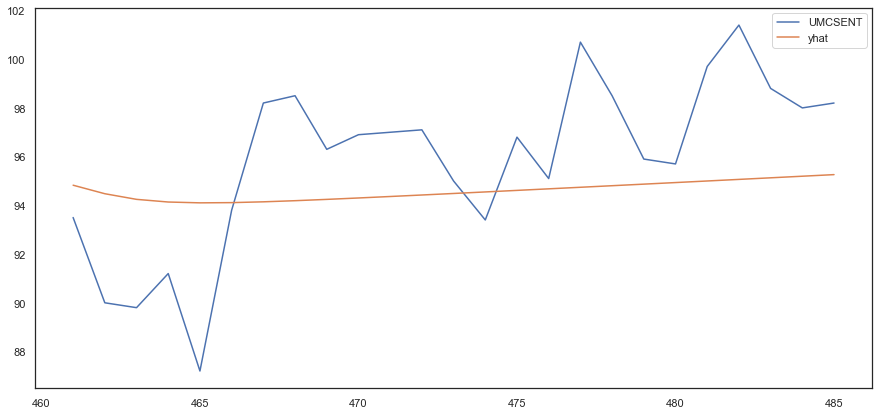

In [9]:
tes_pred = testdata[[target]]
tes_pred['yhat'] = predictions['yhat'].values
pd.concat([tes_pred[target], tes_pred['yhat']],axis=1).dropna(axis=1).plot(figsize=(15,7))


-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 3.00
    MSE (Mean Squared Error = 12.30
    MAPE (Mean Absolute Percent Error) = 3%
    RMSE (Root Mean Squared Error) = 3.5074
    Normalized RMSE (MinMax) = 25%
    Normalized RMSE (as Std Dev of Actuals)= 100%


(3.5074280235625594, 99.71247728096881)

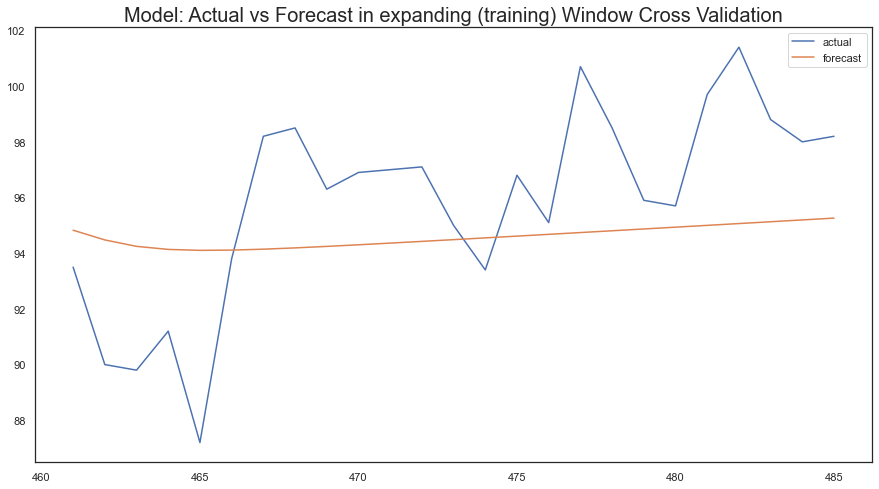

In [10]:
from auto_ts import print_ts_model_stats
print_ts_model_stats(tes_pred[target], tes_pred['yhat'])